In [1]:
import os
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
from PythonFiles.model import model, preprocessing, split_forecasts_by_week, \
forecast_by_week, train_test_split
from PythonFiles.PlottingFunctions import plot_coverage, print_forecasts_by_week, hyperparameter_boxplots, plot_model_results_by_hp, hp_color_plot
from PythonFiles.Configuration import Configuration
from PythonFiles.HpTuning import get_data, restore_HP_results, objectiveFNN, generate_model_results_by_hp_dict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from ray import tune
configuration = Configuration()
data_splits_dict = get_data(truncate=False, with_features=True, config=configuration)[0]
train = data_splits_dict["with_features_2001"][0]
test = data_splits_dict["with_features_2001"][1]

In [8]:
experiment_path = "/home/reffert/ray_results/objectiveFNN_2023-05-27_09-47-44"
df = restore_HP_results(experiment_path, objectiveFNN, train, test, configuration)
hp_search_space = {
    "num_hidden_dimensions": tune.grid_search([[5], [20]]),
    "context_length":tune.grid_search([4, 52, 104]),
    "epochs":tune.grid_search([50, 200]),
    "prediction_length" : tune.grid_search([4, 104]), # This parameter should be removed!! and set to 4 
    "num_batches_per_epoch":tune.grid_search([25, 100]),
    "batch_normalization":tune.grid_search([True, False]),
    "batch_size":tune.grid_search([20, 64]),
    }
if "config/num_hidden_dimensions"in list(df.columns):
    df["config/num_hidden_dimensions"]=df["config/num_hidden_dimensions"].apply(tuple)
df = df.loc[df["config/prediction_length"]==4]

Loading results from /home/reffert/ray_results/objectiveFNN_2023-05-27_09-47-44...


2023-05-29 15:36:12,225	INFO worker.py:1553 -- Started a local Ray instance.
2023-05-29 15:36:25,251	WARNING tuner_internal.py:292 -- The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.
2023-05-29 15:36:25,427	INFO experiment_analysis.py:789 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


In [9]:
model_results_by_hp, overall_df = generate_model_results_by_hp_dict(df, hp_search_space)

There are combinations with fewer modelRuns!!
                           total_modelruns  independent_combinations
modelruns_per_combination                                           
5.0                                    420                      84.0
4.0                                     48                      12.0


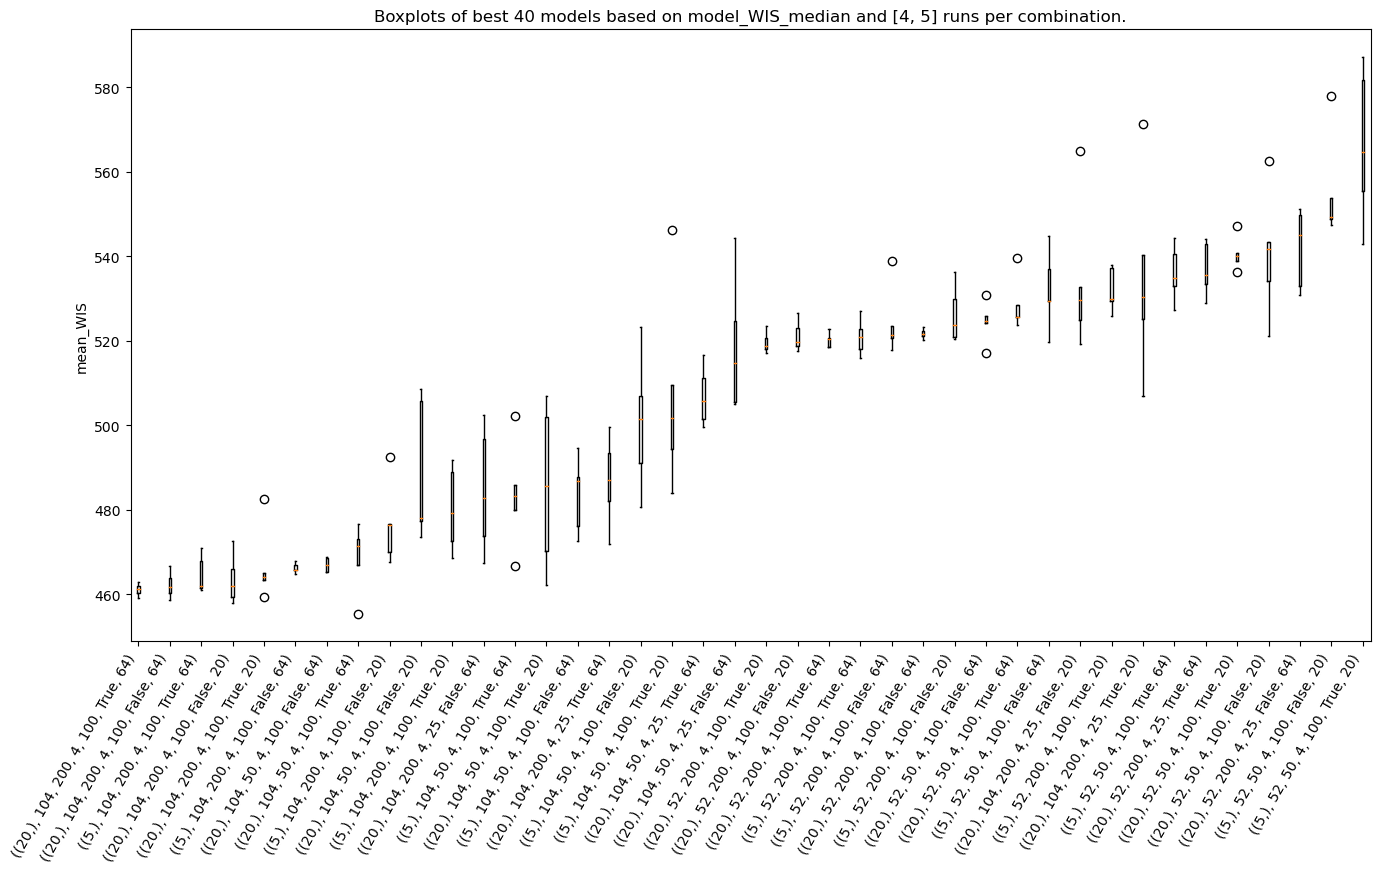

In [10]:
plot_model_results_by_hp(configuration, model_results_by_hp, hp_search_space, number_of_plots=40, col="mean_WIS",figsize=(16, 9), overall_df=overall_df, sort_by="model_WIS_median", plottype="best", plot = "bp")

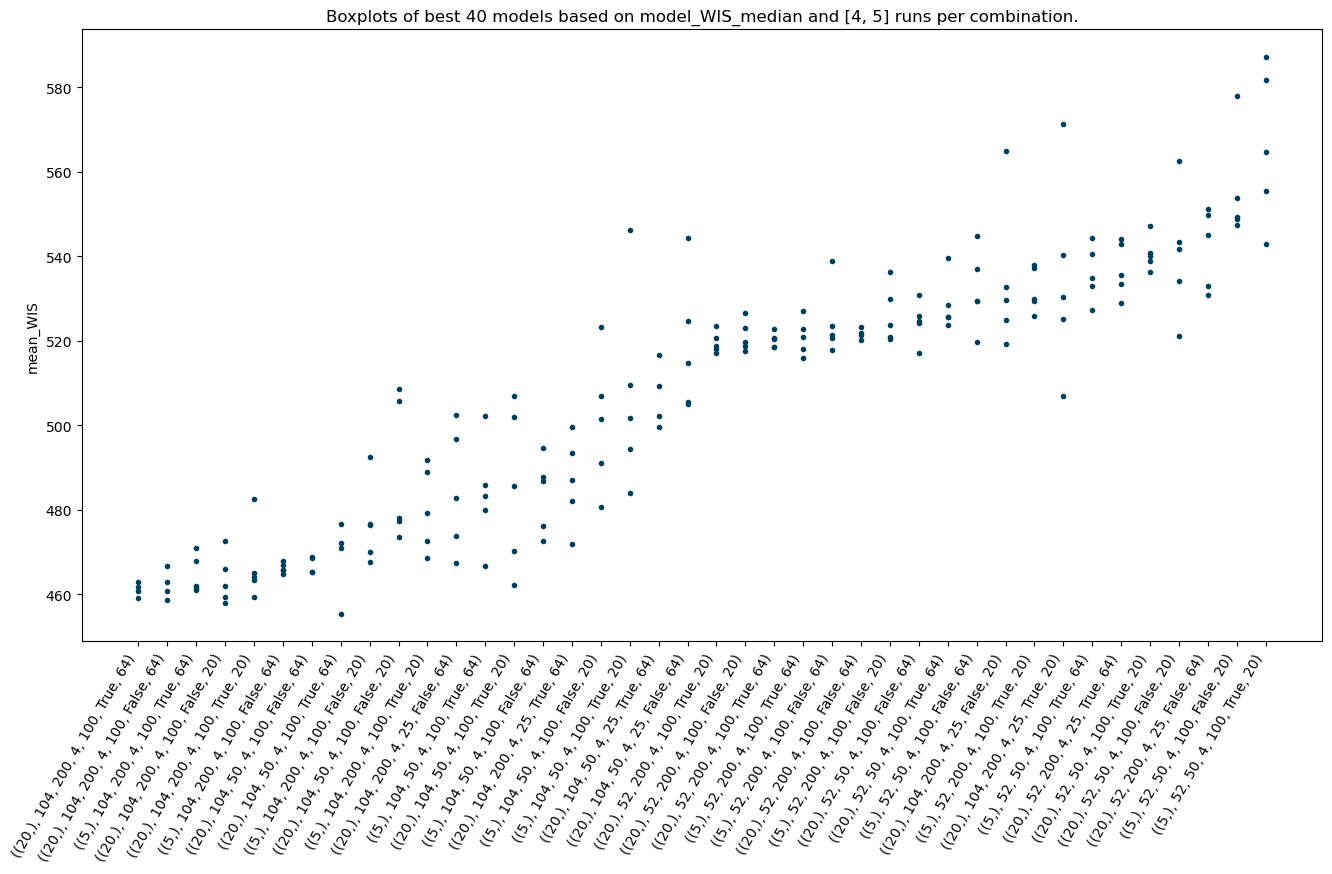

In [11]:

'''
col: "mean_WIS", "time_this_iter_s"
sort_by: "mean_WIS", "time_this_iter_s", "model_WIS_mean", "model_WIS_variance", "model_WIS_sd", "model_WIS_median", "model_time_mean", "model_time_variance", "model_time_sd",\
         "model_time_median"(, "shape") 
plottype: "unordered"(not ordered), "best" or "worst"
'''
plot_model_results_by_hp(configuration, model_results_by_hp, hp_search_space, number_of_plots=40, col="mean_WIS",figsize=(16, 9), overall_df=overall_df, sort_by="model_WIS_median", plottype="best", plot = "scatter")

In [12]:
added_cols = ["model_WIS_mean", "model_WIS_variance", "model_WIS_sd", "model_WIS_median", "model_time_mean", "model_time_variance", "model_time_sd",\
         "model_time_median", "shape"] 
# We can't drop duplicates of num_hidden_dimensions as this column is reported as lists
display(overall_df.sort_values("model_WIS_mean")[added_cols+[col for col in df.columns if ("config" in col)]].drop_duplicates().head(20))

,model_WIS_mean,model_WIS_variance,model_WIS_sd,model_WIS_median,model_time_mean,model_time_variance,model_time_sd,model_time_median,shape,config/batch_normalization,config/batch_size,config/context_length,config/epochs,config/num_batches_per_epoch,config/num_hidden_dimensions,config/prediction_length
669,461.111997,2.480487,1.574956,461.213958,6705.704299,2.679607e+06,1636.950379,6354.191892,4.0,True,64,104,200,100,"(20,)",4
479,462.227523,11.712924,3.422415,461.797539,7073.590085,3.998831e+06,1999.707674,7026.678557,4.0,False,64,104,200,100,"(20,)",4
285,463.567452,34.803760,5.899471,461.950769,2927.373635,5.682769e+05,753.841413,2807.299752,5.0,False,20,104,200,100,"(20,)",4
430,464.588499,20.395781,4.516169,461.864060,6867.410571,3.313835e+06,1820.394078,7261.687445,5.0,True,64,104,200,100,"(5,)",4
239,466.144634,1.486837,1.219359,465.716150,7210.663849,3.111420e+06,1763.921882,7410.431010,5.0,False,64,104,200,100,"(5,)",4
92,466.792597,81.614343,9.034066,463.999257,2971.142241,1.080849e+06,1039.638934,2641.000566,5.0,True,20,104,200,100,"(20,)",4
467,466.937028,3.911818,1.977832,466.951701,2043.098293,1.995334e+05,446.691635,2207.892228,4.0,False,64,104,50,100,"(20,)",4
82,468.712372,85.113742,9.225711,471.414112,2661.552167,1.333080e+06,1154.590779,2669.749491,4.0,True,64,104,50,100,"(20,)",4
620,476.593415,94.107768,9.700916,476.368422,3172.831376,8.844942e+05,940.475516,3028.461003,5.0,False,20,104,200,100,"(5,)",4
236,480.199894,100.935808,10.046681,479.311548,3104.868618,1.240238e+06,1113.659539,2999.034067,5.0,True,20,104,200,100,"(5,)",4


468


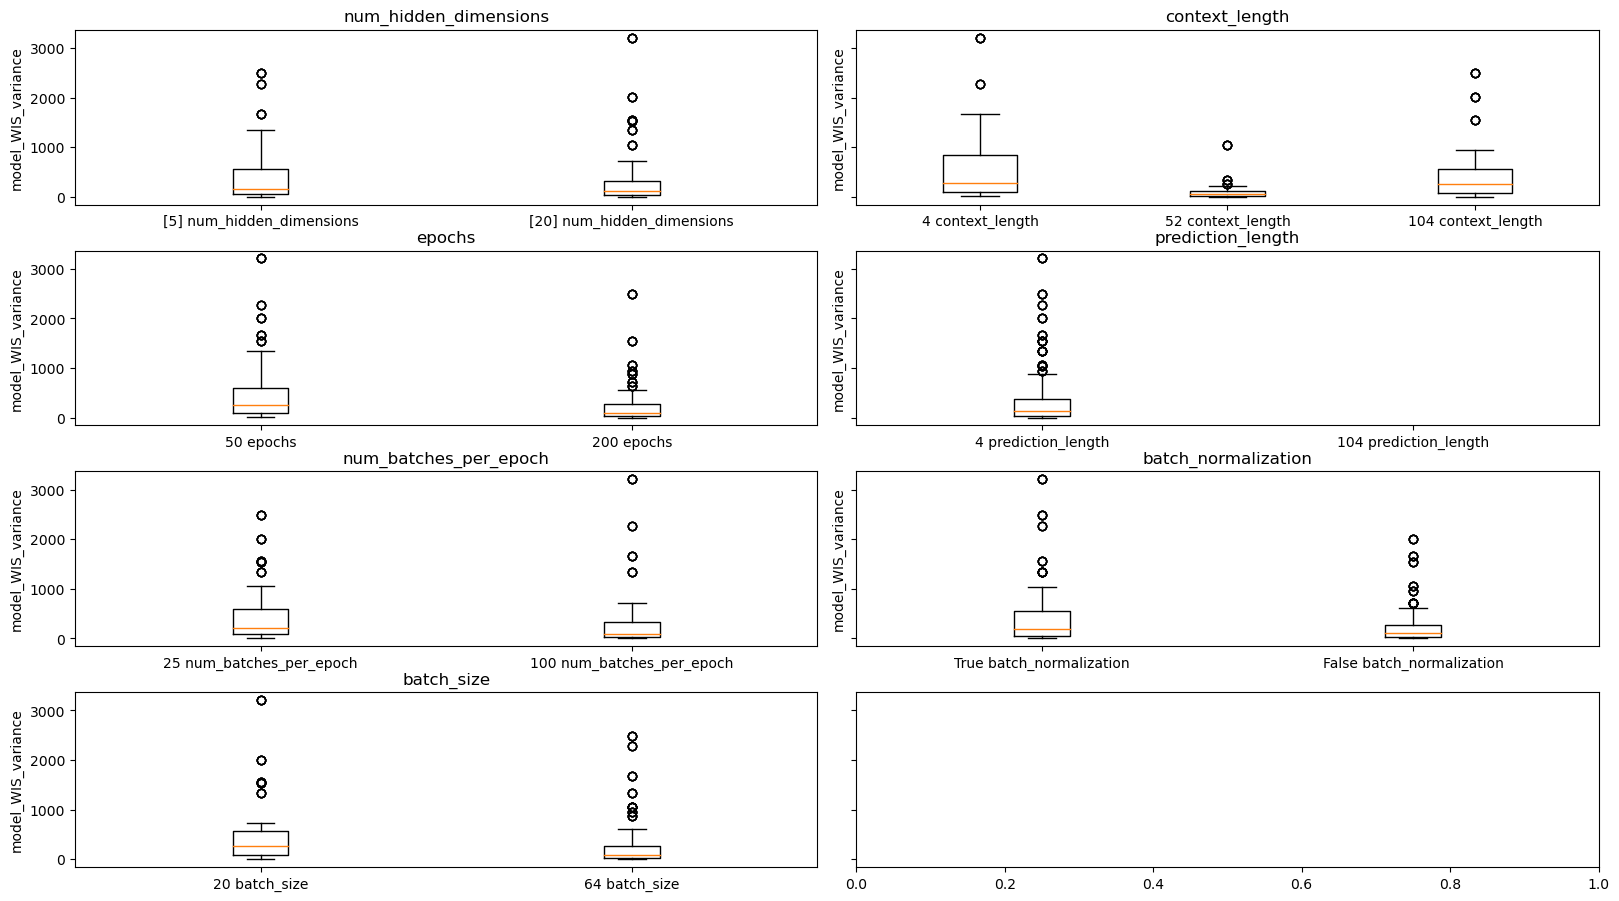

________________


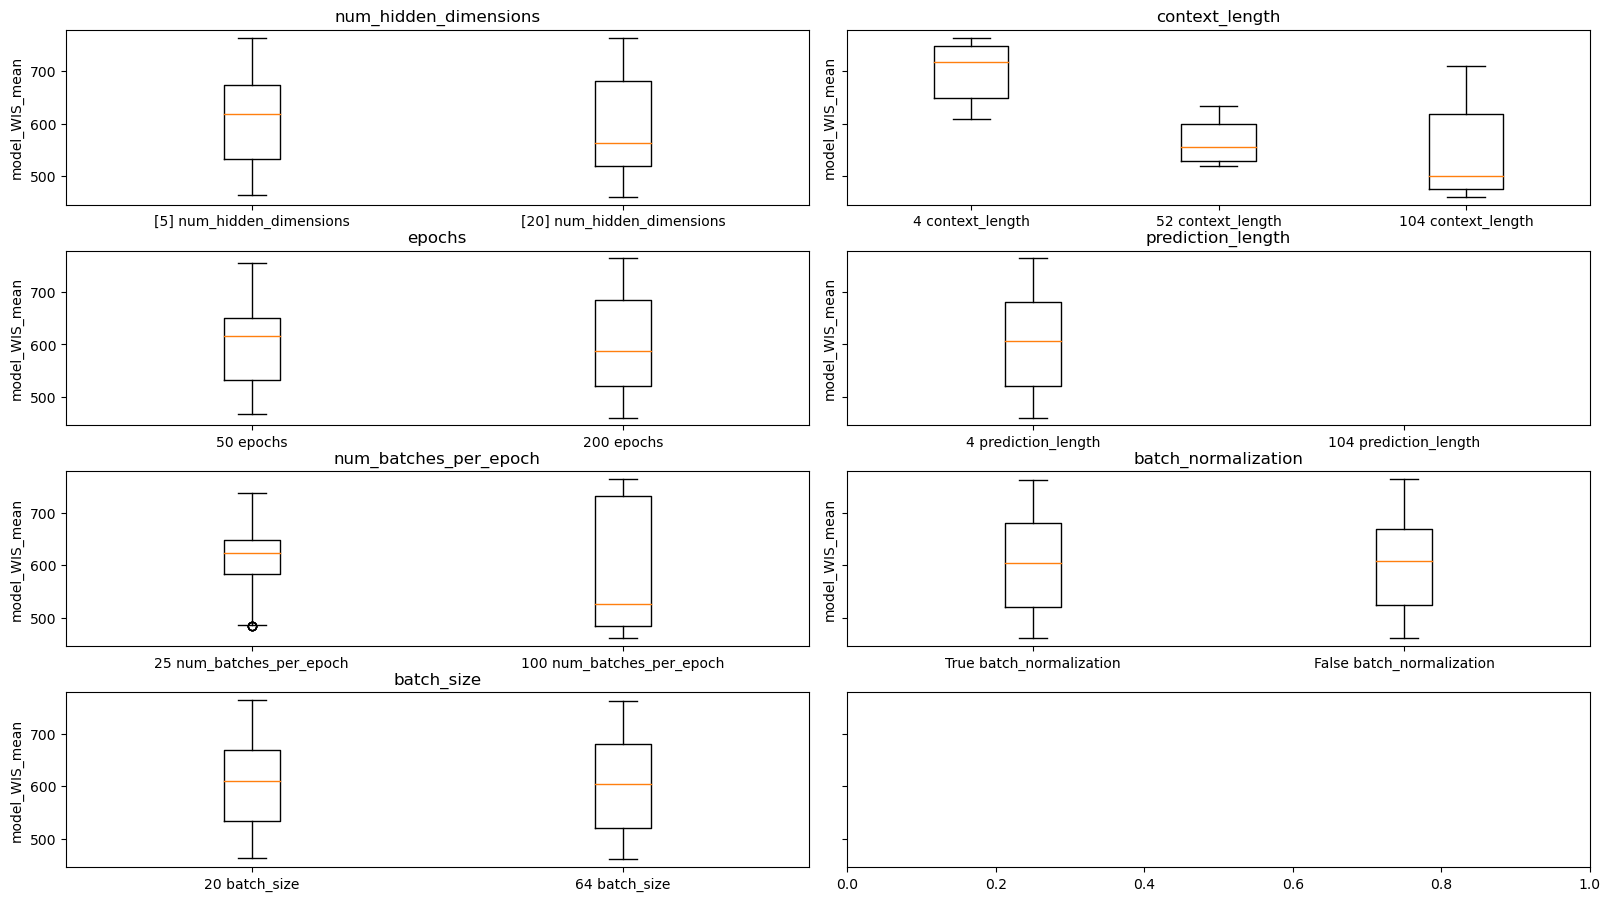

In [13]:
#unique_df = overall_df[added_cols+[col for col in df.columns if ("config" in col)&("cardinality" not in col)]].drop_duplicates()
#print(len(unique_df))
def hyperparameter_boxplots1(results_df, hp_search_space, col="mean_WIS"):
    """
    Plot the hyperparameters as boxplots.
    """
    # Create a dict of filtered dfs and x_tick- renamings
    hp_plots = dict()
    for key in hp_search_space.keys():
        if type(hp_search_space[key]) == type(dict()):
            search_grid = hp_search_space[key][list(hp_search_space[key].keys())[0]]
            #search_grid = [tuple(s) if isinstance(s, list) else s for s in search_grid]
            #print(search_grid)
            hp_plots[key] = {"cols" : [f"{i} {key}" for i in search_grid], "df": [results_df.loc[results_df[f'config/{key}'].apply(lambda x: x == tuple(i)), col] if (isinstance(i, list)) else results_df.loc[results_df[f'config/{key}']==i, col] for i in search_grid]} # the if isinstance is necessary for the num_hidden_layers of the FNN
    # plot the boxplots
    nrows = int(len(hp_plots.keys())/2) + int(len(hp_plots.keys())%2)
    fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=(16, 9), sharey=True)
    fig.tight_layout(pad=1.2)
    plotnumber = [0, 0]
    for key in hp_plots.keys():
        if list(hp_plots.keys()).index(key)%2 == 1:
            plotnumber[1] = 1
        else:
            if list(hp_plots.keys()).index(key) > 1:
                plotnumber[0] += 1
            plotnumber[1] = 0
        axs[tuple(plotnumber)].boxplot(hp_plots[key]["df"])
        axs[tuple(plotnumber)].set_title(key)
        axs[tuple(plotnumber)].set_xticks([i for i in range(1, len(hp_plots[key]["df"])+1)], hp_plots[key]["cols"])
        axs[tuple(plotnumber)].set_ylabel(col)
    plt.show()

print(len(overall_df))
hyperparameter_boxplots(overall_df, hp_search_space, col="model_WIS_variance")
print("________________")
hyperparameter_boxplots(overall_df, hp_search_space, col="model_WIS_mean")

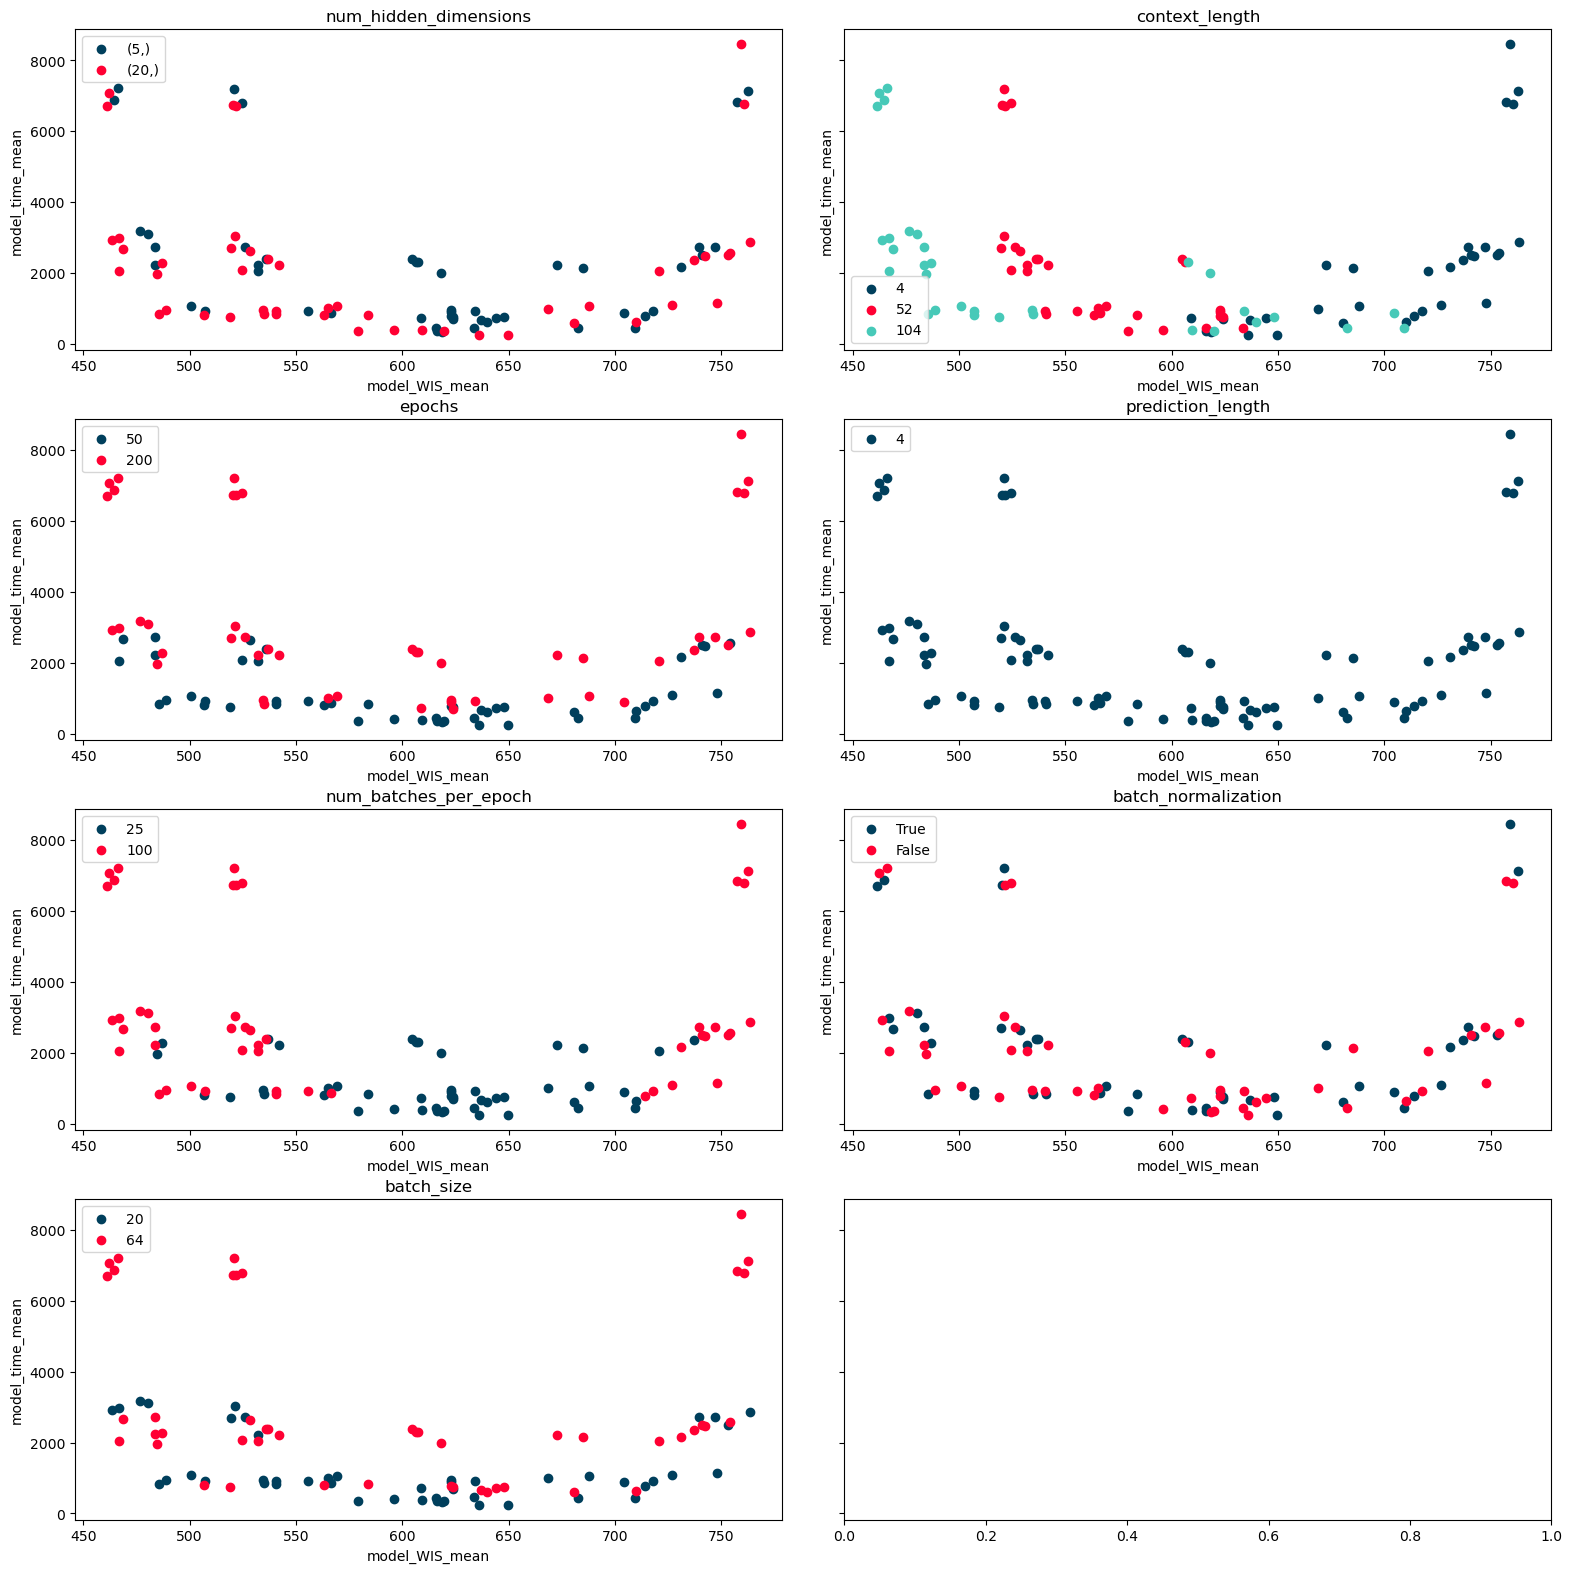

In [14]:
hp_color_plot(configuration, overall_df, hp_search_space, )

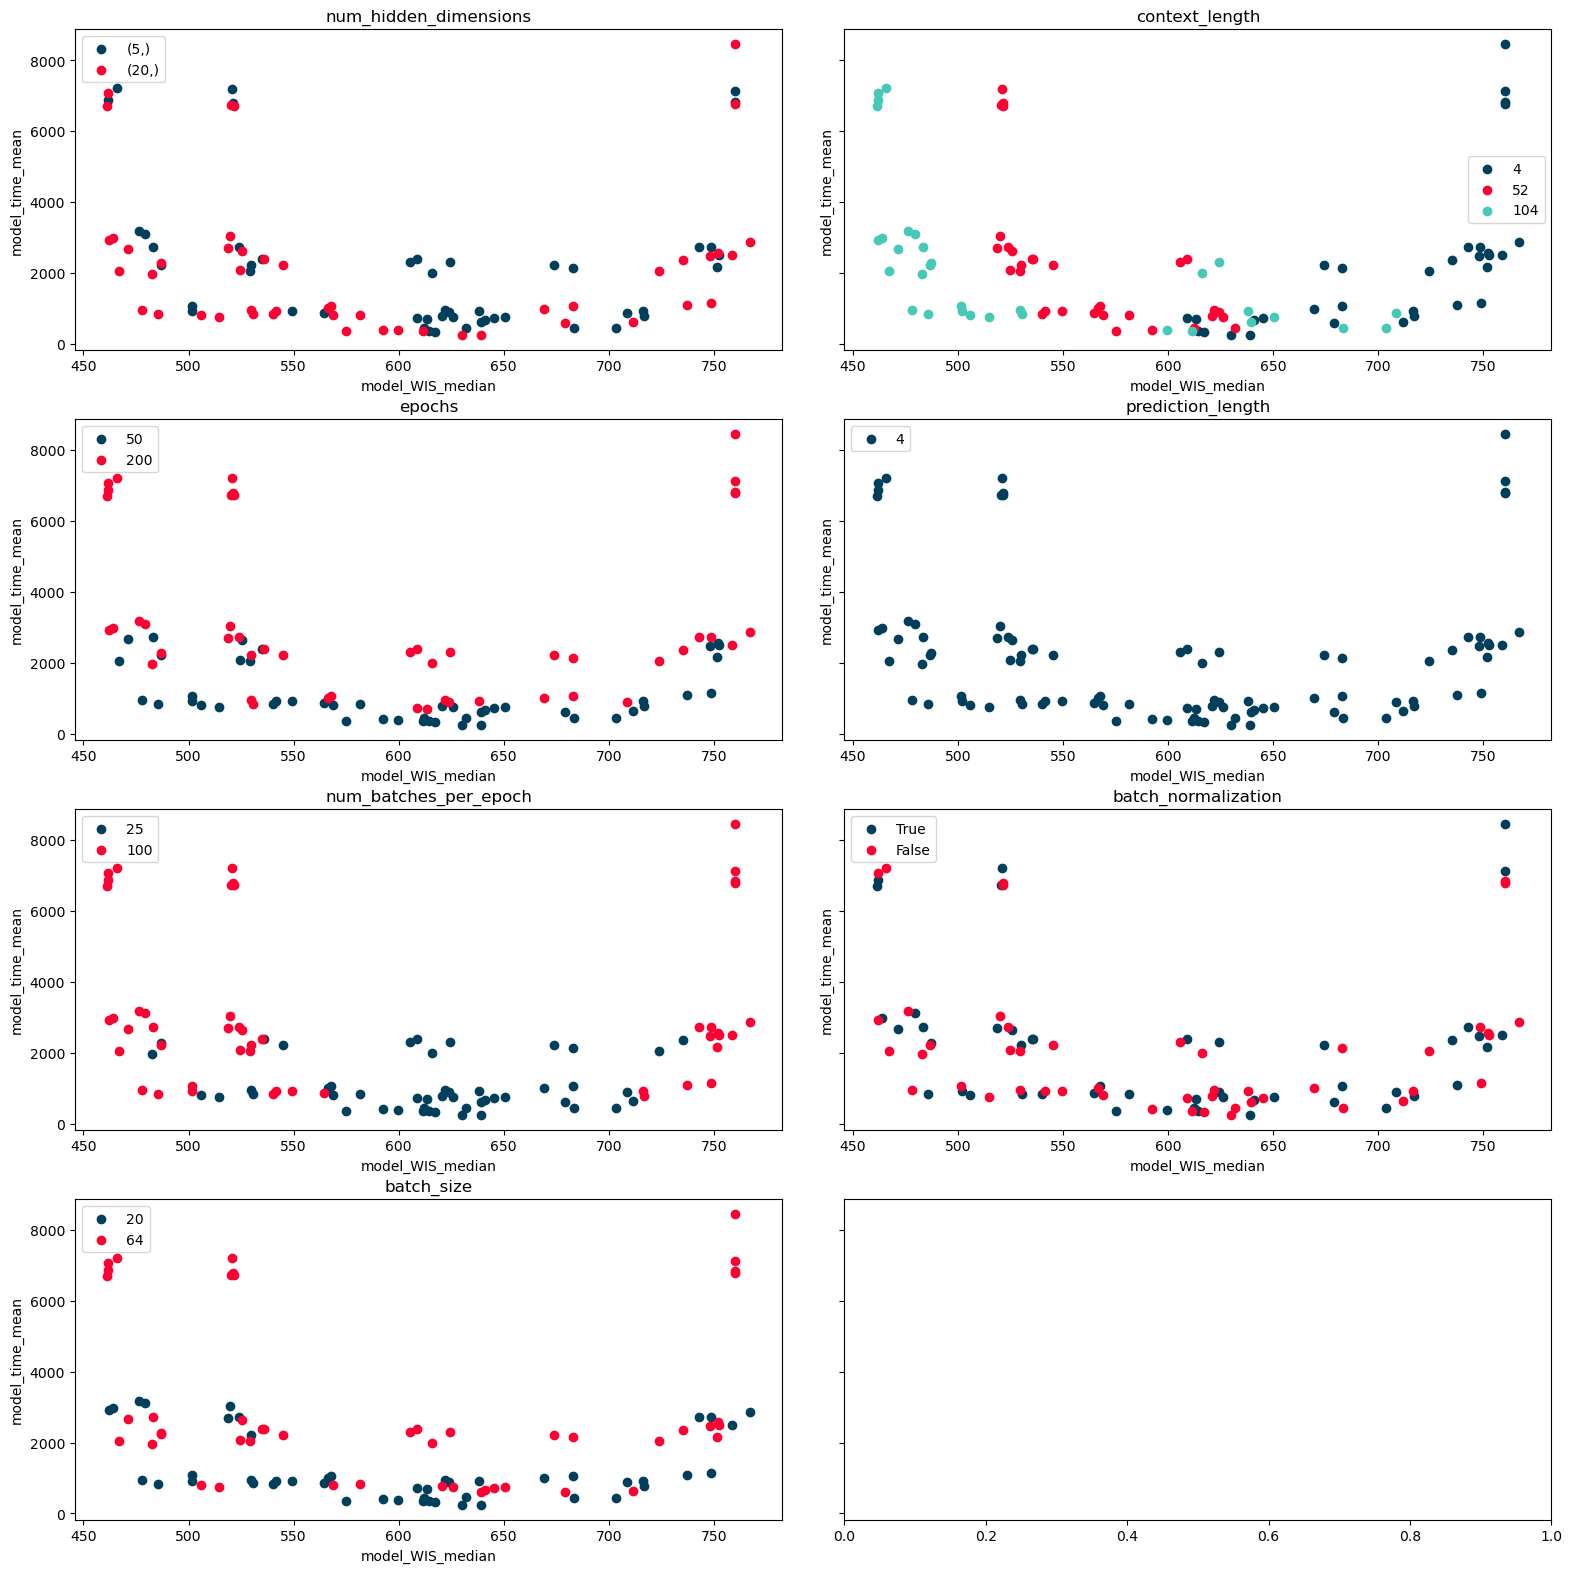

In [15]:
hp_color_plot(configuration, overall_df, hp_search_space, x_axis="model_WIS_median", y_axis="model_time_mean")